From https://docs.dgl.ai/en/0.5.x/guide/training-node.html

In [1]:
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from dgl.data import DGLDataset
import numpy as np
import scipy.sparse as sp
import networkx as nx
import itertools

Using backend: pytorch


In [2]:
edges = pd.read_csv('large_twitch_edges.csv', header=0)
edges.columns = ['source', 'target']
features = pd.read_csv('large_twitch_features.csv', header=0)

In [4]:
features['created_at'] = pd.to_datetime(features['created_at'])
features['updated_at'] = pd.to_datetime(features['updated_at'])

features['delta_days'] = (features['updated_at'] - features['created_at']).dt.total_seconds()/(60*60*24)

features['language'] = pd.factorize(features['language'])[0]

In [3]:
# Minimize the graph (if needed)

G = nx.from_pandas_edgelist(edges, source='source', target='target', create_using=nx.Graph())
degree_dict = dict(G.degree)
selected_nodes = []
for i in degree_dict:
    if degree_dict[i] >= 300:
        selected_nodes.append(i)
        
edges_filtered = edges[edges["source"].isin(selected_nodes)]
edges_filtered = edges[edges["target"].isin(selected_nodes)]

nodes_filtered = set(edges_filtered['source'].tolist() + edges_filtered['target'].tolist())
features_filtered = features.loc[nodes_filtered]

Sdict = dict(zip(nodes_filtered, range(len(nodes_filtered))))
edges_filtered['source'] = edges_filtered['source'].map(Sdict)
edges_filtered['target'] = edges_filtered['target'].map(Sdict)

In [7]:
class TwitchGamersDataset(DGLDataset):
    def __init__(self):
        super().__init__(name='twitch_gamers')

    def process(self):
        nodes_data = features_filtered
        edges_data = edges_filtered

        node_features = torch.from_numpy(nodes_data[['views', 'mature', 'life_time', 'delta_days', 'dead_account', 'affiliate']].to_numpy()).float()
        node_labels = torch.from_numpy(nodes_data['language'].astype('category').cat.codes.copy().to_numpy())
        edges_src = torch.from_numpy(edges_data['source'].to_numpy())
        edges_dst = torch.from_numpy(edges_data['target'].to_numpy())

        self.graph = dgl.graph((edges_src, edges_dst), num_nodes=nodes_data.shape[0])
        self.graph.ndata['feat'] = node_features
        self.graph.ndata['label'] = node_labels

        # If your dataset is a node classification dataset, you will need to assign
        # masks indicating whether a node belongs to training, validation, and test set.
        n_nodes = nodes_data.shape[0]
        n_train = int(n_nodes * 0.6)
        n_val = int(n_nodes * 0.2)
        train_mask = torch.zeros(n_nodes, dtype=torch.bool)
        val_mask = torch.zeros(n_nodes, dtype=torch.bool)
        test_mask = torch.zeros(n_nodes, dtype=torch.bool)
        train_mask[:n_train] = True
        val_mask[n_train:n_train + n_val] = True
        test_mask[n_train + n_val:] = True
        self.graph.ndata['train_mask'] = train_mask
        self.graph.ndata['val_mask'] = val_mask
        self.graph.ndata['test_mask'] = test_mask

    def __getitem__(self, i):
        return self.graph

    def __len__(self):
        return 1

dataset = TwitchGamersDataset()
graph = dataset[0]

print(graph)

Graph(num_nodes=53732, num_edges=1174645,
      ndata_schemes={'feat': Scheme(shape=(6,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int8), 'train_mask': Scheme(shape=(), dtype=torch.bool), 'val_mask': Scheme(shape=(), dtype=torch.bool), 'test_mask': Scheme(shape=(), dtype=torch.bool)}
      edata_schemes={})


In [8]:
import dgl.nn as dglnn
import torch.nn as nn
import torch.nn.functional as F
class SAGE(nn.Module):
    def __init__(self, in_feats, hid_feats, out_feats):
        super().__init__()
        self.conv1 = dglnn.SAGEConv(
            in_feats=in_feats, out_feats=hid_feats, aggregator_type='mean')
        self.conv2 = dglnn.SAGEConv(
            in_feats=hid_feats, out_feats=out_feats, aggregator_type='mean')

    def forward(self, graph, inputs):
        # inputs are features of nodes
        h = self.conv1(graph, inputs)
        h = F.relu(h)
        h = self.conv2(graph, h)
        return h

In [9]:
node_features = graph.ndata['feat']
node_labels = graph.ndata['label']
train_mask = graph.ndata['train_mask']
valid_mask = graph.ndata['val_mask']
test_mask = graph.ndata['test_mask']
n_features = node_features.shape[1]
n_labels = int(node_labels.max().item() + 1)

In [10]:
def evaluate(model, graph, features, labels, mask):
    model.eval()
    with torch.no_grad():
        logits = model(graph, features)
        logits = logits[mask]
        labels = labels[mask]
        _, indices = torch.max(logits, dim=1)
        correct = torch.sum(indices == labels)
        return correct.item() * 1.0 / len(labels)

In [11]:
model = SAGE(in_feats=n_features, hid_feats=100, out_feats=n_labels)
opt = torch.optim.Adam(model.parameters())
logs = []

for epoch in range(1000):
    model.train()
    # forward propagation by using all nodes
    logits = model(graph, node_features)
    # compute loss
    loss = F.cross_entropy(logits[train_mask], node_labels[train_mask].long())
    # compute validation accuracy
    acc = evaluate(model, graph, node_features, node_labels, valid_mask)
    # compute validation accuracy
    test_acc = evaluate(model, graph, node_features, node_labels, test_mask)
    # backward propagation
    opt.zero_grad()
    loss.backward()
    opt.step()
    #print(loss.item())
    logs.append([loss, acc, test_acc])
    
    if epoch % 100 == 0:
        print('In epoch {}, loss: {:.3f}, val acc: {:.3f}, test acc: {:.3f}'.format(
            epoch, loss, acc, test_acc))

In epoch 0, loss: 758215.500, val acc: 0.495, test acc: 0.487
In epoch 100, loss: 17750.746, val acc: 0.706, test acc: 0.714
In epoch 200, loss: 8867.270, val acc: 0.725, test acc: 0.731
In epoch 300, loss: 11290.305, val acc: 0.803, test acc: 0.804
In epoch 400, loss: 7996.579, val acc: 0.717, test acc: 0.723
In epoch 500, loss: 4904.978, val acc: 0.768, test acc: 0.767
In epoch 600, loss: 11802.953, val acc: 0.372, test acc: 0.378
In epoch 700, loss: 4783.618, val acc: 0.725, test acc: 0.736
In epoch 800, loss: 5888.924, val acc: 0.781, test acc: 0.783
In epoch 900, loss: 12345.340, val acc: 0.662, test acc: 0.663


In [12]:
# Max accuracy
max(np.array(logs)[:,2])

0.8149250953754537

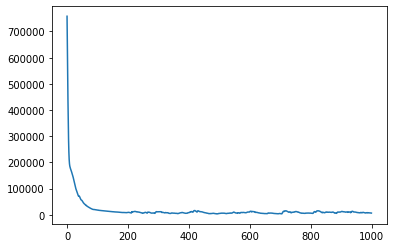

In [13]:
import matplotlib.pyplot as plt
plt.plot(np.array(logs)[:,0])

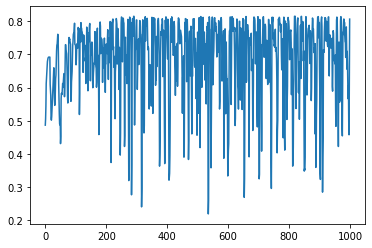

In [14]:
plt.plot(np.array(logs)[:,2])